# Lightweight Fine-Tuning Project

Lightweight fine-tuning is one of the most important techniques for adapting foundation models, because it allows you to modify foundation models for your needs without needing substantial computational resources.
In this project, I am applying parameter-efficient fine-tuning using the Hugging Face peft library. Hugging Face PEFT allows you to fine-tune a model without having to fine-tune all of its parameters.

* PEFT technique: LoRA
* Model: AutoModelForSequenceClassification
* Evaluation approach: Accuracy
* Fine-tuning dataset: ag_news (https://huggingface.co/datasets/fancyzhx/ag_news)

## Loading Hugging Face Dataset

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. (https://huggingface.co/datasets/fancyzhx/ag_news)

In [1]:
from datasets import load_dataset

# load the train and test split
splits = ["train", "test"]
ds = {split: ds for split, ds in zip(splits, load_dataset("ag_news", split=splits))}

# taking a subset of the original data (5000 rows)
for split in splits:
    ds[split] = ds[split].shuffle(seed=42).select(range(5000))

print(ds)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text', 'label'],
    num_rows: 5000
}), 'test': Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})}


## Loading Hugging Face Tokenizer

I am using "distilbert-base-uncased". This model is a distilled version of the BERT base model. This model is uncased: it does not make a difference between english and English. (https://huggingface.co/distilbert/distilbert-base-uncased)

In [2]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
def preprocess_function(examples):
    """preprocess the dataset by returning the tokenized examples
    """
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True)
    
    return tokens

In [4]:
# tokenizing the train and test dataset
tokenized_ds = {}
for split in splits:
    tokenized_ds[split] = ds[split].map(preprocess_function, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [5]:
# validating the tokenizer function
tokenized_ds["train"][0]["input_ids"][:10]

[101, 7269, 11498, 2135, 6924, 2011, 9326, 4559, 10134, 2031]

## Loading a Hugging Face foundational model
Here I am using the AutoModelForSequenceClassification which has a classification head on top of the model outputs which can be easily trained with the base model. (https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification)



In [6]:
# loading a pre-trained model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=4,
    id2label={0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"},
    label2id={"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In PyTorch, setting param.requires_grad = False is a way to freeze the parameters of a model or a part of a model. This means that the gradients for these parameters will not be computed during backpropagation, and thus, the parameters will not be updated during training. When using a pre-trained model, you may want to keep the pre-trained layers fixed and only train the new layers added for a specific task.

In [7]:
# freeze all the parameters in the base model
for param in model.base_model.parameters():
    param.requires_grad = False
    
model.classifier

Linear(in_features=768, out_features=4, bias=True)

In [8]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [9]:
# defining the evaluation metric: Accuracy
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

## Instantiating the foundational model

The Trainer class provides an API for feature-complete training in PyTorch, and it supports distributed training on multiple GPUs/TPUs. Trainer goes hand-in-hand with the TrainingArguments class, which offers a wide range of options to customize how a model is trained. Together, these two classes provide a complete training API.

Introducing some parameters in the Trainer method for following reasons:
* DataCollatorWithPadding: Data collators are objects that will form a batch by using a list of dataset elements as input. To be able to build batches, data collators may apply some processing (like padding). This will dynamically pad the inputs received.
* TrainingArguments: TrainingArguments is the subset of the arguments we use in our example scripts which relate to the training loop itself.
    * output_dir (str) — The output directory where the model predictions and checkpoints will be written.
    * per_device_train_batch_size - This parameter specifies the batch size to be used for training on each individual device (GPU or CPU) when using distributed or parallel training.
    * per_device_eval_batch_size - This parameter specifies the batch size to be used for evaluation on each individual device (GPU or CPU) when using distributed or parallel evaluation.
    * learning_rate - controls how much to change the model in response to the estimated error each time the model's weights are updated during training
    * num_train_epochs - number of times the entire training dataset is passed through the model during the training process.
    * weight_decay - refers to a regularization technique used to prevent overfitting. 
    * evaluation_strategy - evaluation is performed at the end of each epoch

In [10]:
import numpy as np
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

trainer = Trainer(
    model = model,
    args = TrainingArguments(
        output_dir = "./data/news_classification",
        learning_rate = 2e-5,
        
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 16,
        
        num_train_epochs = 5,
        weight_decay = 0.01,
        
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        load_best_model_at_end = True,
    ),
    
    train_dataset = tokenized_ds["train"],
    eval_dataset = tokenized_ds["test"],
    tokenizer = tokenizer,
    data_collator = DataCollatorWithPadding(tokenizer),
    compute_metrics = compute_metrics,
)

## Evaluating the pretrained model

In [11]:
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.3892381191253662,
 'eval_accuracy': 0.25,
 'eval_runtime': 79.6021,
 'eval_samples_per_second': 62.812,
 'eval_steps_per_second': 3.932}

In [12]:
# view some results
import pandas as pd

df = pd.DataFrame(tokenized_ds["test"])
df = df[["text", "label"]]

# Replace <br /> tags in the text with spaces
df["text"] = df["text"].str.replace("<br />", " ")

# Add the model predictions to the dataframe
predictions = trainer.predict(tokenized_ds["test"])
df["predicted_label"] = np.argmax(predictions[0], axis=1)

df.head(10)

,text,label,predicted_label
0,Indian board plans own telecast of Australia s...,1,0
1,Stocks Higher on Drop in Jobless Claims A shar...,2,0
2,"Nuggets 112, Raptors 106 Carmelo Anthony score...",1,0
3,Stocks Higher on Drop in Jobless Claims A shar...,2,0
4,REVIEW: 'Half-Life 2' a Tech Masterpiece (AP) ...,3,0
5,China's inflation rate slows sharply but probl...,0,0
6,ADV: Try Currency Trading Risk-Free 30 Days 24...,2,0
7,OPEC Can Raise Output Capacity by 1 Mln Barrel...,2,0
8,Intel gets off chip speed roller coaster: Tech...,3,0
9,Amazon Snaps Up China's Largest Web Retailer (...,2,0


## Performing Parameter-Efficient Fine-Tuning

### Creating a Peft Model
The PEFT config specifies the adapter configuration for your parameter-efficient fine-tuning process. The base class for this is a PeftConfig, but this example will use a LoraConfig, the subclass used for low rank adaptation (LoRA)

Low-Rank Adaptation (LoRA) is a PEFT method that decomposes a large matrix into two smaller low-rank matrices in the attention layers. This drastically reduces the number of parameters that need to be fine-tuned.

In [22]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(
              in_features=768, out_features=768, bias=True
              (lora_dropout): ModuleDict(
                (default): Identity()
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=768, out_features=4, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=4, out_features=768, bias=False)
              )
              (lora_e

* target_modules - The names of the modules to apply the adapter to. If this is specified, only the modules with the specified names will be replaced.
* r - The rank r of the low-rank matrices is a hyperparameter that determines the size of these matrices. Smaller values of r lead to fewer parameters and faster training, while larger values might capture more task-specific information.
* task_type - refers to the specific type of task the model is being fine-tuned or adapted for.
* lora_alpha - controls the strength of the low-rank adaptation regularization applied during training

In [23]:
# instantiating a LoRA configuration, a subclass used for the low rank adaptation
from peft import LoraConfig, TaskType
peft_config = LoraConfig(target_modules = [
                                        "q_lin",
                                        "k_lin",
                                        "v_lin",
                                        "out_lin"],
                         r = 4,
                         task_type = TaskType.SEQ_CLS,
                         lora_alpha = 16
                        
)

In [24]:
# converting the transformer model into PEFT model
from peft import get_peft_model
lora_model = get_peft_model(model, peft_config)

In [25]:
lora_model.print_trainable_parameters()

trainable params: 147,456 || all params: 67,697,672 || trainable%: 0.2178154663870864


In [26]:
lora_model.classifier

ModulesToSaveWrapper(
  (original_module): Linear(in_features=768, out_features=4, bias=True)
  (modules_to_save): ModuleDict(
    (default): Linear(in_features=768, out_features=4, bias=True)
  )
)

In [27]:
print(lora_model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): MultiHeadSelfAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): Linear(
                  in_features=768, out_features=768, bias=True
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=4, bias=False)
                

In [28]:
# LoRA takes in "labels", not "label" so we need to rename
# training and testing sets
train_lora = tokenized_ds['train'].rename_column('label', 'labels')
test_lora = tokenized_ds['test'].rename_column('label', 'labels')

## Training the Peft Model

In [29]:
# Fine tuning the model

import numpy as np
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

trainer = Trainer(
    model = lora_model,
    args = TrainingArguments(
        output_dir = "./data/news_classification",
        
        learning_rate = 2e-5,
        
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 16,
        
        num_train_epochs = 5,
        weight_decay = 0.01,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        load_best_model_at_end = True,
    ),
    
    train_dataset = train_lora,
    eval_dataset = test_lora,
    tokenizer = tokenizer,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.251862,0.648400
2,1.271100,0.897540,0.830800
3,1.271100,0.752858,0.856400
4,0.860800,0.699458,0.859000
5,0.723900,0.683833,0.860800


Checkpoint destination directory ./data/news_classification/checkpoint-313 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./data/news_classification/checkpoint-626 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./data/news_classification/checkpoint-939 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./data/news_classification/checkpoint-1252 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./data/news_classification/checkpoint-1565 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1565, training_loss=0.9414280218057358, metrics={'train_runtime': 1430.5688, 'train_samples_per_second': 17.476, 'train_steps_per_second': 1.094, 'total_flos': 3368721408000000.0, 'train_loss': 0.9414280218057358, 'epoch': 5.0})

## Saving the Peft Model

In [30]:
# Saving the peft model
lora_model.save_pretrained("cls-lora")

## Loading the saved Peft Model

In [31]:
from peft import AutoPeftModelForSequenceClassification
model_lora = AutoPeftModelForSequenceClassification.from_pretrained("cls-lora", 
                                                                    num_labels = 4,
                                                                    id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"},
                                                                    label2id = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3})

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
trainer = Trainer(model_lora,
                  eval_dataset=test_lora)

## Evaluating the Peft Model

In [33]:
# evaluating the fine-tuned model
trainer.evaluate()

{'eval_loss': 0.683832585811615,
 'eval_runtime': 88.3752,
 'eval_samples_per_second': 56.577,
 'eval_steps_per_second': 7.072}

In [34]:
# view some results
import pandas as pd

df_tuned = pd.DataFrame(test_lora)
df_tuned = df_tuned[["text", "labels"]]

# Replace <br /> tags in the text with spaces
df_tuned["text"] = df_tuned["text"].str.replace("<br />", " ")

# Add the model predictions to the dataframe
predictions = trainer.predict(test_lora)
df_tuned["predicted_label"] = np.argmax(predictions[0], axis=1)

df_tuned.head(10)

,text,labels,predicted_label
0,Indian board plans own telecast of Australia s...,1,1
1,Stocks Higher on Drop in Jobless Claims A shar...,2,2
2,"Nuggets 112, Raptors 106 Carmelo Anthony score...",1,1
3,Stocks Higher on Drop in Jobless Claims A shar...,2,2
4,REVIEW: 'Half-Life 2' a Tech Masterpiece (AP) ...,3,3
5,China's inflation rate slows sharply but probl...,0,2
6,ADV: Try Currency Trading Risk-Free 30 Days 24...,2,3
7,OPEC Can Raise Output Capacity by 1 Mln Barrel...,2,2
8,Intel gets off chip speed roller coaster: Tech...,3,3
9,Amazon Snaps Up China's Largest Web Retailer (...,2,2


## Comparison between the two models
* Baseline vs Fine-tuned (PEFT)

In [35]:
import matplotlib.pyplot as plt

#### Number of correctly predicted

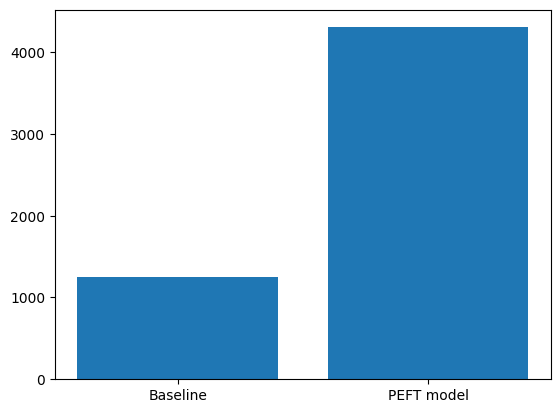

In [36]:
data = {"Baseline":(df.label == df.predicted_label).sum(), "PEFT model":(df_tuned.labels == df_tuned.predicted_label).sum()}
plt.bar(data.keys(), data.values());

#### Number of incorrectly predicted

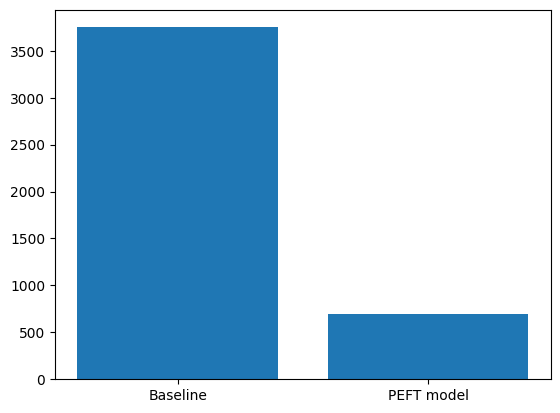

In [37]:
data = {"Baseline":(df.label != df.predicted_label).sum(), "PEFT model":(df_tuned.labels != df_tuned.predicted_label).sum()}
plt.bar(data.keys(), data.values());

#### Evaluation loss

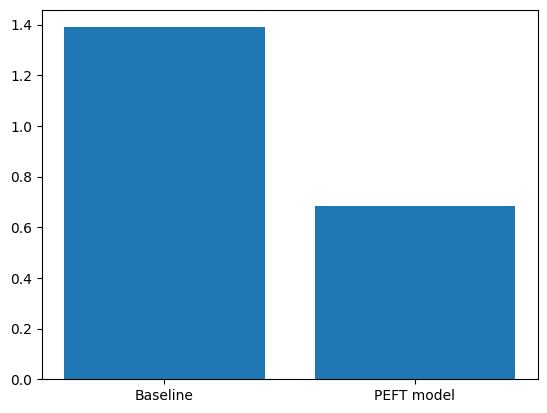

In [39]:
data = {"Baseline":1.3892, "PEFT model":0.6838}
plt.bar(data.keys(), data.values());